<a href="https://colab.research.google.com/github/arps1214p/safeai/blob/main/default_resnet_for_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리 Import 및 환경 설정

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision import datasets, models, transforms

import PIL
from PIL import Image

import math
import random
import seaborn as sn
import pandas as pd
import numpy as np
from pathlib import Path
from skimage import io
import pickle
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm_notebook

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)
print("Pillow Version: ", PIL.__version__)

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

PyTorch Version:  2.6.0+cu124
Torchvision Version:  0.21.0+cu124
Pillow Version:  11.2.1
CUDA is not available.  Training on CPU ...


# 데이터 가져오기

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alexattia/the-simpsons-characters-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/the-simpsons-characters-dataset


In [ ]:
train_dir = Path('/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset/simpsons_dataset/')
test_dir = Path('/kaggle/input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset')

# 함수 및 클래스 정의


## Train-val split 및 testset 가져오기

In [ ]:
class TrainValTestSplit():

  def __init__(self, train_dir, test_dir):

    self.train_dir = train_dir
    self.test_dir = test_dir
    # 하위 디렉토리를 순회하며 이미지의 경로를 리스트로 저장
    self.train_val_files_path = sorted(list(self.train_dir.rglob('*.jpg')))
    self.test_path = sorted(list(self.test_dir.rglob('*.jpg')))
    self.train_val_labels = [path.parent.name for path in self.train_val_files_path]

  def get_path(self):

    train_files_path, val_files_path = train_test_split(self.train_val_files_path, test_size = 0.3, \
                                          stratify=self.train_val_labels, random_state = 42)

    train_val_files_path = {'train': train_files_path, 'val': val_files_path}

    return train_val_files_path, self.test_path

  def get_n_classes(self):
    return len(np.unique(self.train_val_labels))


In [ ]:
TrainValTestPath = TrainValTestSplit(train_dir, test_dir)
train_path, test_path = TrainValTestPath.get_path()

## 모델 학습 함수

In [ ]:
def train_model(model, dataloaders, cost, optimizer, save_best_weights_path, save_last_weights_path, best_acc, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    val_loss_history = []
    train_acc_history = []
    train_loss_history = []
    lr_find_lr = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # train과 val 단계에 따라 model 모드 변경
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm_notebook(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward
                # train 모드라면 hitstory 저장
                with torch.set_grad_enabled(phase == 'train'):
                    # inception module을 사용하는 모델인경우 loss 설정
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = cost(outputs, labels)
                        loss2 = cost(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = cost(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimizer + scheduler
                    # scheduler의 경우 일단 비활성화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        #scheduler.step()
                        #lr_step = optimizer_ft.state_dict()["param_groups"][0]["lr"]
                        #lr_find_lr.append(lr_step)

                # 현재 에포크의 손실 저장
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # loss, acc 계산
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # 현재 epoch의 정확도가 best_acc 보다 큰 경우 best 모델을 변경
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            # 현재 epoch의 정확도를 history에 저장
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()

    # 학습시간 계산
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # best model 로드
    model.load_state_dict(best_model_wts)

    history_val = {'loss': val_loss_history, 'acc': val_acc_history}
    history_train = {'loss': train_loss_history, 'acc': train_acc_history}

    return model, history_val, history_train, time_elapsed, lr_find_lr, best_acc

## transfer learning 시 동작 결정 함수

In [ ]:
# feature_extracting이 설정된 경우 fc레이어의 param만 학습
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

## torch.models로부터 모델을 불러오는 함수

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=False):

    model_ft = None
    input_size = 0

    if model_name == "resnet152":
        """ Resnet152
        """
        model_ft = models.resnet152(pretrained=use_pretrained)
        # pretrained=true일때
        # feature_extract=true인 경우 마지막 fc레이어의 param만 학습
        set_parameter_requires_grad(model_ft, feature_extract)
        # fc레이어의 input 개수 로드
        num_ftrs = model_ft.fc.in_features
        # fc레이어의 output 개수 설정
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == 'resnet18':
        """ ResNet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet161(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

## 데이터셋 클래스

In [ ]:
class SimpsonsDataset(Dataset):

    def __init__(self, files_path, data_transforms):
      self.files_path = files_path
      self.transform = data_transforms

      if 'test' not in str(self.files_path[0]):
        self.labels = [path.parent.name for path in self.files_path]
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.labels)

        with open('label_encoder.pkl', 'wb') as le_dump_file:
            pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
      return len(self.files_path)

    def __getitem__(self, idx):

      img_path = str(self.files_path[idx])
      image = Image.open(img_path)
      image = self.transform(image)

      if 'test' in str(self.files_path[0]):
        return image
      else:
        label_str = str(self.files_path[idx].parent.name)
        label = self.label_encoder.transform([label_str]).item()

        return image, label

# 모델 설정

In [ ]:
model_name = 'resnet18'

num_classes = TrainValTestPath.get_n_classes()
batch_size = 32
num_epochs = 2

# device 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# pretrained 모델을 이용하는 경우
# feature_extract = False - 전체 모델 학습
# feature_extract = True - Fc 레이어만 학습
feature_extract = False

save_last_weights_path = '/kaggle/working/' + model_name + '-' + '_last_weights.pth'
save_best_weights_path = '/kaggle/working/' + model_name + '-' + '_best_weights.pth'

model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=False)

model_ft = model_ft.to(device)

# 데이터 Augmentation

In [ ]:
# ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) -> imagenet 데이터셋의 통계 기반
# TODO
# simpson 데이터셋 전체의 std와 mean 계산 후 정규화에 이용

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((input_size,input_size)),
        #transforms.CenterCrop(input_size),
        transforms.RandomChoice( [
                                  transforms.RandomHorizontalFlip(p=0.5),
                                  transforms.ColorJitter(contrast=0.9),
                                  transforms.ColorJitter(brightness=0.1),
                                  transforms.RandomApply( [ transforms.RandomHorizontalFlip(p=1), transforms.ColorJitter(contrast=0.9) ], p=0.5),
                                  transforms.RandomApply( [ transforms.RandomHorizontalFlip(p=1), transforms.ColorJitter(brightness=0.1) ], p=0.5),
                                  ] ),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((input_size,input_size)),
        #transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 모델에 전달될 데이터 설정

### Dataset

In [ ]:
image_datasets = {mode: SimpsonsDataset(train_path[mode], data_transforms[mode]) for mode in ['train', 'val']}
image_datasets_test = SimpsonsDataset(test_path, data_transforms['val'])

### Dataloader

In [ ]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

num_workers = 4
dataloaders_dict = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True,
                                                         num_workers=num_workers, worker_init_fn=seed_worker,generator=g),
                    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=True,
                                                       num_workers=num_workers,worker_init_fn=seed_worker,generator=g)}
dataloader_test = torch.utils.data.DataLoader(image_datasets_test, batch_size=batch_size, shuffle=False,
                                              num_workers=num_workers, worker_init_fn=seed_worker,generator=g)

### 샘플 출력

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

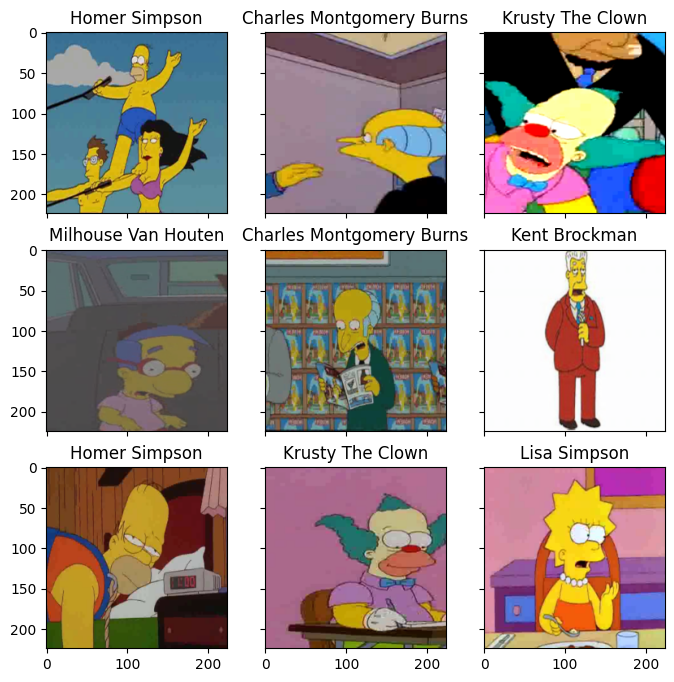

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 4500))
    im_val, label = image_datasets['train'][random_characters]
    # 캐릭터 이름 출력
    img_label = " ".join(map(lambda x: x.capitalize(),\
                image_datasets['val'].label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

# 파라미터 설정

In [ ]:
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            #print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            pass
            #print("\t",name)

Params to learn:


# 학습

학습은
 lr_scheduler.CyclicLR를 이용해 최적의 lr 범위를 찾고
 이를 이용하여 실제 학습하는 두 단계로 이루어짐

## 1. lr 범위 결정

Оптимизацию lr будем проводить используя циклическое изменение его значений в указанном диапазоне. Вначале необходимо определить оптимальные границы диапазона. Для этого проведем тестовый запуск. Выберем step size таким образом, чтобы во время тестового запуска lr линейно возрастал. <br>

После чего построим график accuracy относительно learning rate, на основании графика выберем диапазон значений.

Метод: https://arxiv.org/pdf/1506.01186.pdf

In [ ]:
# base_lr = 0.00001
# max_lr = 0.05
# lr_find_epochs = 2

# cost = nn.CrossEntropyLoss()

# optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9, nesterov = True)

# step_size = lr_find_epochs * len(dataloaders_dict['train'])

# scheduler = optim.lr_scheduler.CyclicLR(optimizer_ft, base_lr = base_lr, max_lr = max_lr, step_size_up=step_size, mode='exp_range', gamma=0.99994, scale_mode='cycle', cycle_momentum=True, base_momentum=0.8, max_momentum=0.9, last_epoch=-1)

# def search_lr(lr_find_epochs):

#   accs = []
#   lr_find_lr = []
#   acc_sum = 0.0

#   for i in range(lr_find_epochs):
#     print("epoch {}".format(i))
#     for inputs, labels in tqdm_notebook(dataloaders_dict['train']):

#       inputs = inputs.to(device)
#       labels = labels.to(device)

#       model_ft.train()
#       optimizer_ft.zero_grad()

#       outputs = model_ft(inputs)
#       loss = cost(outputs, labels)
#       preds = torch.argmax(outputs, 1)
#       acc_running = torch.sum(preds == labels.data).item()
#       acc_sum += torch.sum(preds == labels.data).item()

#       loss.backward()
#       optimizer_ft.step()
#       scheduler.step()

#       lr_step = optimizer_ft.state_dict()["param_groups"][0]["lr"]
#       lr_find_lr.append(lr_step)

#       accs.append(acc_running)
#   accs = np.array(accs) / acc_sum

#   return lr_find_lr, accs

# lr_find_lr, accs = search_lr(lr_find_epochs)

# plt.figure(figsize=(20,10))
# plt.plot(np.array(lr_find_lr), np.array(accs));

## 2. 모델 학습

In [ ]:
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=False)
model_ft = model_ft.to(device)

In [ ]:
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            #print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            pass
            print("\t",name)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

In [ ]:
#base_lr = 0.0012
#max_lr = 0.0022
num_epoch = 30

cost = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(params_to_update, lr=0.002, momentum=0.9, nesterov = True)
#step_size = 2 * math.ceil( len(dataloaders_dict['train']) / batch_size )
#scheduler = optim.lr_scheduler.CyclicLR(optimizer_ft, base_lr = base_lr, max_lr = max_lr, step_size_up=step_size, mode='exp_range', gamma=0.994, scale_mode='cycle', cycle_momentum=True, base_momentum=0.8, max_momentum=0.9, last_epoch=-1)

In [ ]:
val_loss = []
val_acc = []
train_loss = []
train_acc = []
lr_cycle = []
best_acc = .0

In [ ]:
for i in range(1):

    image_datasets = {mode: SimpsonsDataset(train_path[mode], data_transforms[mode]) for mode in ['train', 'val']}

    dataloaders_dict = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=0,
                                                            worker_init_fn=seed_worker,generator=g),
                          'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False, num_workers=0,
                                                            worker_init_fn=seed_worker,generator=g)}

    model, history_val, history_train, time_elapsed, lr_find_lr, best_acc = train_model(model_ft, dataloaders_dict, cost, optimizer_ft, save_best_weights_path, save_last_weights_path, best_acc = best_acc, num_epochs=num_epoch, is_inception=(model_name=="inception"))

    val_loss += history_val['loss']
    val_acc += history_val['acc']
    train_loss += history_train['loss']
    train_acc += history_train['acc']
    lr_cycle += lr_find_lr

Epoch 1/30
----------


  0%|          | 0/458 [00:00<?, ?it/s]

train Loss: 2.6069 Acc: 0.2789


  0%|          | 0/197 [00:00<?, ?it/s]

val Loss: 1.9238 Acc: 0.4912

Epoch 2/30
----------


  0%|          | 0/458 [00:00<?, ?it/s]

train Loss: 1.6360 Acc: 0.5655


  0%|          | 0/197 [00:00<?, ?it/s]

val Loss: 1.3123 Acc: 0.6516

Epoch 3/30
----------


  0%|          | 0/458 [00:00<?, ?it/s]

train Loss: 1.1671 Acc: 0.6905


  0%|          | 0/197 [00:00<?, ?it/s]

val Loss: 0.9723 Acc: 0.7322

Epoch 4/30
----------


  0%|          | 0/458 [00:00<?, ?it/s]

train Loss: 0.9383 Acc: 0.7457


  0%|          | 0/197 [00:00<?, ?it/s]

val Loss: 0.9996 Acc: 0.7264

Epoch 5/30
----------


  0%|          | 0/458 [00:00<?, ?it/s]

train Loss: 0.7706 Acc: 0.7920


  0%|          | 0/197 [00:00<?, ?it/s]

val Loss: 0.8697 Acc: 0.7701

Epoch 6/30
----------


  0%|          | 0/458 [00:00<?, ?it/s]

train Loss: 0.6503 Acc: 0.8215


  0%|          | 0/197 [00:00<?, ?it/s]

val Loss: 0.7110 Acc: 0.8041

Epoch 7/30
----------


  0%|          | 0/458 [00:00<?, ?it/s]

train Loss: 0.5668 Acc: 0.8452


  0%|          | 0/197 [00:00<?, ?it/s]

val Loss: 0.7322 Acc: 0.8073

Epoch 8/30
----------


  0%|          | 0/458 [00:00<?, ?it/s]

train Loss: 0.4936 Acc: 0.8667


  0%|          | 0/197 [00:00<?, ?it/s]

val Loss: 0.5243 Acc: 0.8591

Epoch 9/30
----------


  0%|          | 0/458 [00:00<?, ?it/s]

train Loss: 0.4184 Acc: 0.8863


  0%|          | 0/197 [00:00<?, ?it/s]

val Loss: 0.5309 Acc: 0.8516

Epoch 10/30
----------


  0%|          | 0/458 [00:00<?, ?it/s]

train Loss: 0.3693 Acc: 0.9013


  0%|          | 0/197 [00:00<?, ?it/s]

val Loss: 0.5385 Acc: 0.8505

Epoch 11/30
----------


  0%|          | 0/458 [00:00<?, ?it/s]

train Loss: 0.3239 Acc: 0.9111


  0%|          | 0/197 [00:00<?, ?it/s]

val Loss: 0.4269 Acc: 0.8831

Epoch 12/30
----------


  0%|          | 0/458 [00:00<?, ?it/s]

train Loss: 0.2794 Acc: 0.9257


  0%|          | 0/197 [00:00<?, ?it/s]

val Loss: 0.5754 Acc: 0.8519

Epoch 13/30
----------


  0%|          | 0/458 [00:00<?, ?it/s]

train Loss: 0.2447 Acc: 0.9347


  0%|          | 0/197 [00:00<?, ?it/s]

val Loss: 0.7169 Acc: 0.8304

Epoch 14/30
----------


  0%|          | 0/458 [00:00<?, ?it/s]

train Loss: 0.2154 Acc: 0.9433


  0%|          | 0/197 [00:00<?, ?it/s]

val Loss: 0.6787 Acc: 0.8369

Epoch 15/30
----------


  0%|          | 0/458 [00:00<?, ?it/s]

train Loss: 0.1881 Acc: 0.9495


  0%|          | 0/197 [00:00<?, ?it/s]

val Loss: 0.3872 Acc: 0.9006

Epoch 16/30
----------


  0%|          | 0/458 [00:00<?, ?it/s]

train Loss: 0.1681 Acc: 0.9550


  0%|          | 0/197 [00:00<?, ?it/s]

val Loss: 0.6583 Acc: 0.8396

Epoch 17/30
----------


  0%|          | 0/458 [00:00<?, ?it/s]

train Loss: 0.1478 Acc: 0.9606


  0%|          | 0/197 [00:00<?, ?it/s]

val Loss: 0.4033 Acc: 0.8970

Epoch 18/30
----------


  0%|          | 0/458 [00:00<?, ?it/s]

train Loss: 0.1305 Acc: 0.9680


  0%|          | 0/197 [00:00<?, ?it/s]

val Loss: 0.4500 Acc: 0.8863

Epoch 19/30
----------


  0%|          | 0/458 [00:00<?, ?it/s]

train Loss: 0.1223 Acc: 0.9704


  0%|          | 0/197 [00:00<?, ?it/s]

val Loss: 0.5180 Acc: 0.8774

Epoch 20/30
----------


  0%|          | 0/458 [00:00<?, ?it/s]

train Loss: 0.0930 Acc: 0.9775


  0%|          | 0/197 [00:00<?, ?it/s]

val Loss: 0.4419 Acc: 0.8889

Epoch 21/30
----------


  0%|          | 0/458 [00:00<?, ?it/s]

train Loss: 0.0986 Acc: 0.9747


  0%|          | 0/197 [00:00<?, ?it/s]

val Loss: 0.4376 Acc: 0.8987

Epoch 22/30
----------


  0%|          | 0/458 [00:00<?, ?it/s]

train Loss: 0.0875 Acc: 0.9784


  0%|          | 0/197 [00:00<?, ?it/s]

val Loss: 0.3724 Acc: 0.9059

Epoch 23/30
----------


  0%|          | 0/458 [00:00<?, ?it/s]

train Loss: 0.0872 Acc: 0.9773


  0%|          | 0/197 [00:00<?, ?it/s]

val Loss: 0.5072 Acc: 0.8822

Epoch 24/30
----------


  0%|          | 0/458 [00:00<?, ?it/s]

train Loss: 0.0811 Acc: 0.9795


  0%|          | 0/197 [00:00<?, ?it/s]

val Loss: 0.3400 Acc: 0.9197

Epoch 25/30
----------


  0%|          | 0/458 [00:00<?, ?it/s]

train Loss: 0.0756 Acc: 0.9814


  0%|          | 0/197 [00:00<?, ?it/s]

val Loss: 0.3531 Acc: 0.9170

Epoch 26/30
----------


  0%|          | 0/458 [00:00<?, ?it/s]

train Loss: 0.0565 Acc: 0.9870


  0%|          | 0/197 [00:00<?, ?it/s]

val Loss: 0.3468 Acc: 0.9174

Epoch 27/30
----------


  0%|          | 0/458 [00:00<?, ?it/s]

train Loss: 0.0588 Acc: 0.9859


  0%|          | 0/197 [00:00<?, ?it/s]

val Loss: 0.3329 Acc: 0.9212

Epoch 28/30
----------


  0%|          | 0/458 [00:00<?, ?it/s]

train Loss: 0.0560 Acc: 0.9862


  0%|          | 0/197 [00:00<?, ?it/s]

val Loss: 0.3206 Acc: 0.9247

Epoch 29/30
----------


  0%|          | 0/458 [00:00<?, ?it/s]

train Loss: 0.0462 Acc: 0.9897


  0%|          | 0/197 [00:00<?, ?it/s]

val Loss: 0.3698 Acc: 0.9189

Epoch 30/30
----------


  0%|          | 0/458 [00:00<?, ?it/s]

train Loss: 0.0444 Acc: 0.9892


  0%|          | 0/197 [00:00<?, ?it/s]

val Loss: 0.3266 Acc: 0.9255

Training complete in 67m 29s
Best val Acc: 0.925478


# 학습 결과 및 모델 분석

## 학습 결과 시각화 함수 선언

In [ ]:
def visualization(train, val, is_loss = True):
  if is_loss:
    plt.figure(figsize=(9,5))
    plt.plot(torch.tensor(train, device =  'cpu'), label = 'Training loss')
    plt.plot(torch.tensor(val, device =  'cpu'), label = 'Val loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

  else:
    plt.figure(figsize=(9,5))
    plt.plot(torch.tensor(train, device =  'cpu'), label = 'Training acc')
    plt.plot(torch.tensor(val, device =  'cpu'), label = 'Val acc')
    plt.title('Training and validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend()
    plt.show()

## confusion_matrix for val data

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=1).numpy()
    return probs

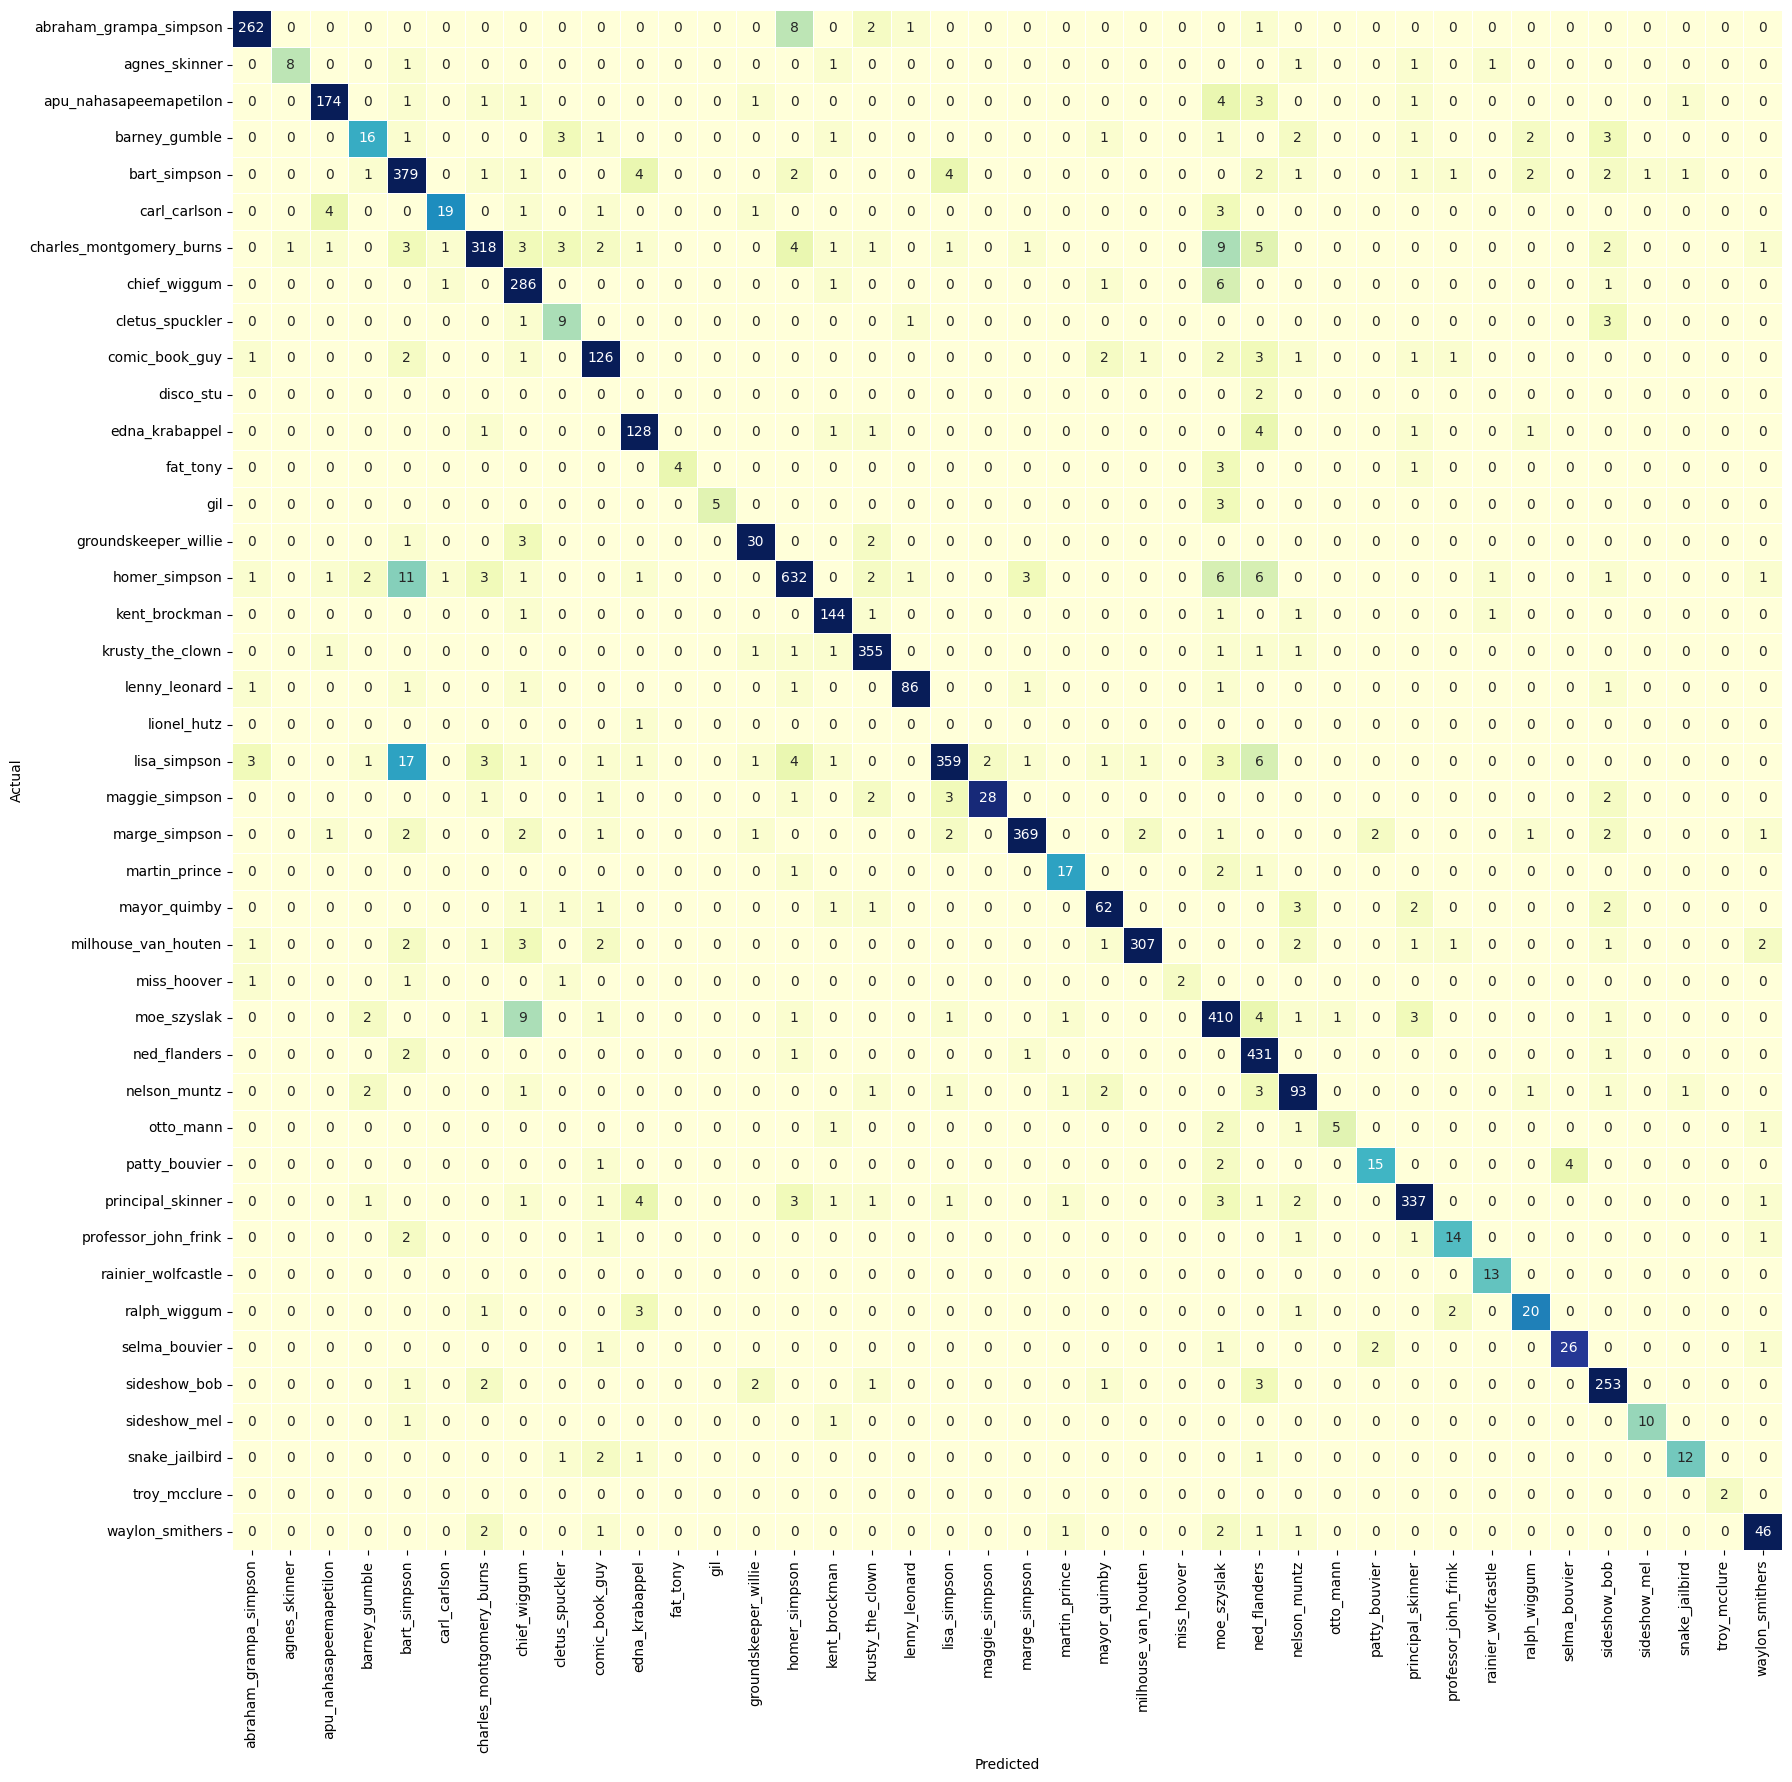

In [ ]:
# confusion_matrix
actual = [image_datasets['val'][i][1] for i in range( len(image_datasets['val']) ) ]
image = [image_datasets['val'][i][0] for i in range( len(image_datasets['val']) ) ]
img_conf_dataloader = torch.utils.data.DataLoader(image, batch_size=batch_size, shuffle=False, num_workers=4,
                                                 worker_init_fn=seed_worker,generator=g)
probs = predict(model_ft, img_conf_dataloader)
preds = np.argmax(probs, axis=1)

df = pd.DataFrame({'actual': actual, 'preds': preds})
confusion_matrix = pd.crosstab(df['actual'], df['preds'], rownames=['Actual'], colnames=['Predicted'], margins = False)
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
yticklabels = label_encoder.classes_
plt.subplots(figsize=(20,20))
sn.heatmap(confusion_matrix, annot=True, fmt="d", linewidths=0.5, cmap="YlGnBu", cbar=False, vmax = 30, yticklabels = yticklabels, xticklabels = label_encoder.classes_[np.unique(preds)]);

## lr_cycle, acc, loss 시각화

In [ ]:
#plt.figure(figsize=(17,10))
#plt.plot(lr_cycle);

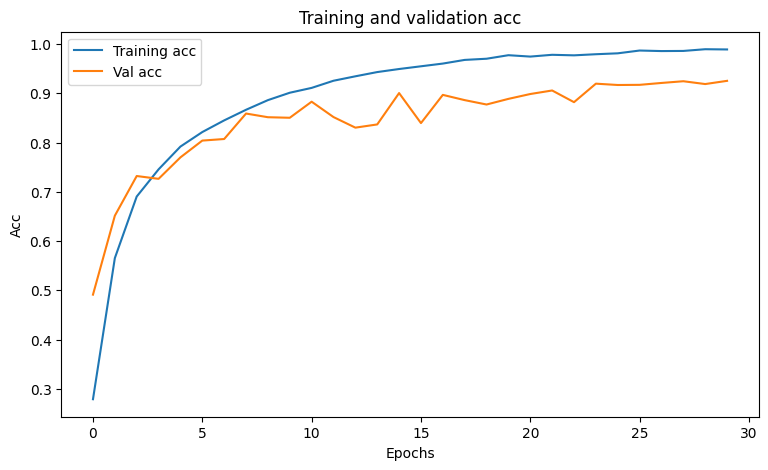

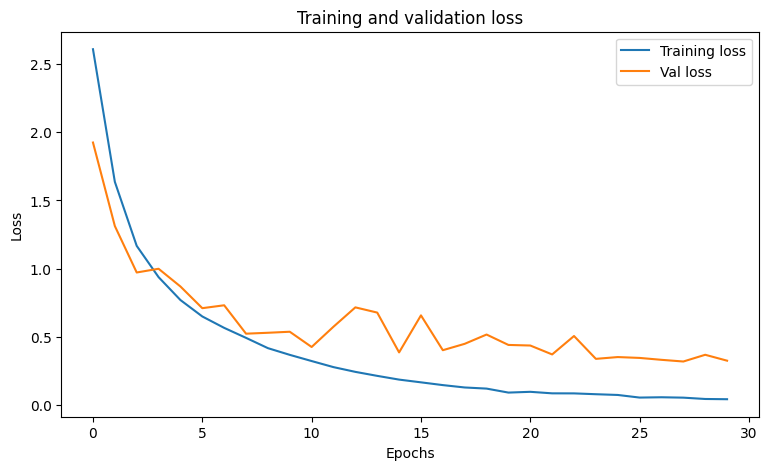

In [ ]:
visualization(train_acc, val_acc, is_loss = False)
print('\n')
visualization(train_loss, val_loss, is_loss = True)

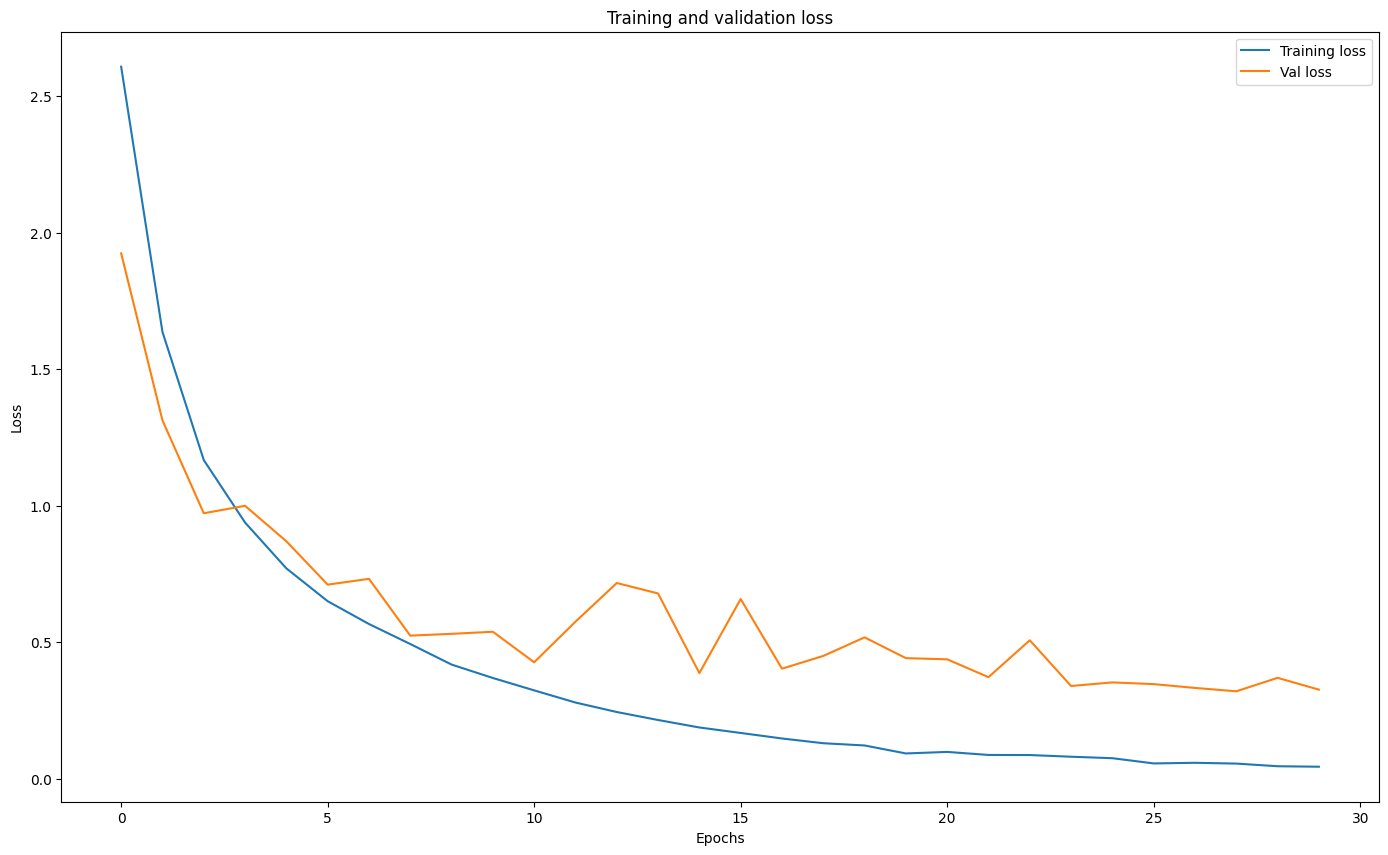

In [ ]:
visualization(train_loss, val_loss, is_loss = True)

# 모델 테스트

## 샘플 테스트

In [ ]:
def predict_one_sample(model, img_tensor, device=device):
    with torch.no_grad():
        img_tensor = img_tensor.to(device)
        model.eval()
        y_hat = model(img_tensor).cpu()
        y_pred = torch.nn.functional.softmax(y_hat, dim=1).numpy()
    return y_pred

## 테스트 샘플 시각화

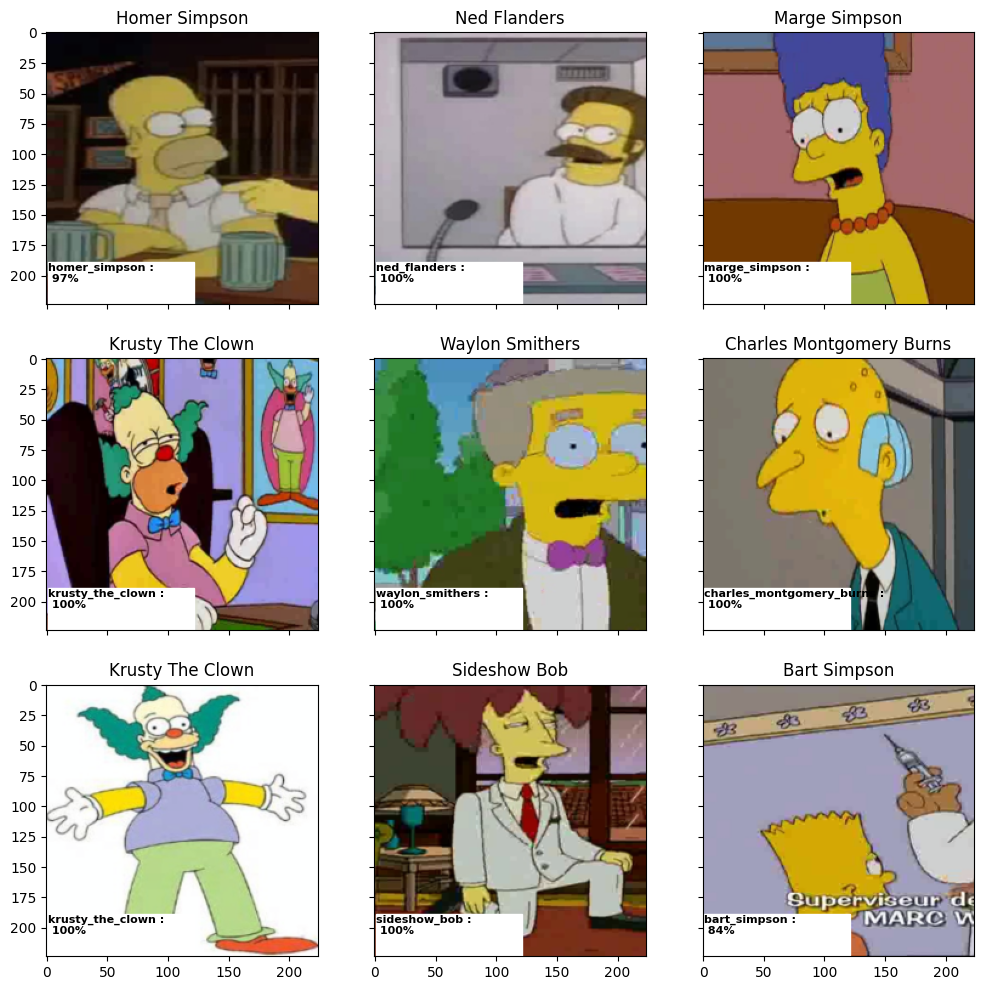

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12), \
                        sharey=True, sharex=True)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 1000))
    im_val, label = image_datasets['val'][random_characters]
    # inverse_transform это метод LabelEncoder(), мы закодировали цифрами классы, с помощью inverse_transform из чисел вернём название класса
    # получаем имя персонажа с заглавных букв
    img_label = " ".join(map(lambda x: x.capitalize(),\
                image_datasets['val'].label_encoder.inverse_transform([label])[0].split('_')))

    imshow(im_val.data.cpu(), \
          title=img_label, plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    # добавим область на которой будем выводить вероятность
    fig_x.add_patch(patches.Rectangle((1, 189), 120, 35, color='white'))
    font0 = FontProperties()
    font = font0.copy()
    prob_pred = predict_one_sample(model_ft, im_val.unsqueeze(0))
    # получаем вероятность
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    #predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} :\n {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 189, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

# 테스트 acc

In [ ]:
probs = predict(model_ft, dataloader_test)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

preds = label_encoder.inverse_transform(np.argmax(probs, axis = 1 ))
test_file_names = [path.name for path in image_datasets_test.files_path]

for i in range(len(test_file_names)):
  test_file_names[i] = test_file_names[i].split('.')[0].rsplit('_', 1)[0]

present_labels = np.unique(test_file_names)

from sklearn.metrics import classification_report
print(classification_report(test_file_names, preds, labels=present_labels))

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.98      1.00      0.99        48
  apu_nahasapeemapetilon       0.98      0.98      0.98        50
            bart_simpson       0.96      1.00      0.98        50
charles_montgomery_burns       0.98      0.96      0.97        48
            chief_wiggum       1.00      0.98      0.99        50
          comic_book_guy       1.00      0.96      0.98        49
          edna_krabappel       0.98      0.96      0.97        50
           homer_simpson       0.98      0.96      0.97        50
           kent_brockman       0.96      0.98      0.97        50
        krusty_the_clown       1.00      1.00      1.00        50
           lenny_leonard       1.00      1.00      1.00        50
            lisa_simpson       1.00      0.98      0.99        50
           marge_simpson       1.00      0.98      0.99        50
            mayor_quimby       0.98      0.96      0.97        50
     milh

In [ ]:
for i in range(len(test_file_names)):
    print(test_file_names[i])

abraham_grampa_simpson
abraham_grampa_simpson
abraham_grampa_simpson
abraham_grampa_simpson
abraham_grampa_simpson
abraham_grampa_simpson
abraham_grampa_simpson
abraham_grampa_simpson
abraham_grampa_simpson
abraham_grampa_simpson
abraham_grampa_simpson
abraham_grampa_simpson
abraham_grampa_simpson
abraham_grampa_simpson
abraham_grampa_simpson
abraham_grampa_simpson
abraham_grampa_simpson
abraham_grampa_simpson
abraham_grampa_simpson
abraham_grampa_simpson
abraham_grampa_simpson
abraham_grampa_simpson
abraham_grampa_simpson
abraham_grampa_simpson
abraham_grampa_simpson
abraham_grampa_simpson
abraham_grampa_simpson
abraham_grampa_simpson
abraham_grampa_simpson
abraham_grampa_simpson
abraham_grampa_simpson
abraham_grampa_simpson
abraham_grampa_simpson
abraham_grampa_simpson
abraham_grampa_simpson
abraham_grampa_simpson
abraham_grampa_simpson
abraham_grampa_simpson
abraham_grampa_simpson
abraham_grampa_simpson
abraham_grampa_simpson
abraham_grampa_simpson
abraham_grampa_simpson
abraham_gra

In [ ]:
#my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
#my_submit.head()
#my_submit.to_csv('simspsons.csv', index=False)